<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-3/1-keras-custom-classifier-with-transfer-learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-3/1-keras-custom-classifier-with-transfer-learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This code is part of [Chapter 3: Cats versus Dogs: Transfer Learning in 30 Lines with Keras](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch03.html).

Note: In order to run this notebook on Google Colab you need to [follow these instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=WzIRIt9d2huC) so that the local data such as the images are available in your Google Drive.

# Building a Custom Classifier in Keras with Transfer Learning

As promised, it’s time to build our state of the art classifier in 30 lines or fewer! At a high level, we will follow the steps shown below:

- **Organize the data**: Download labeled images of cats and dogs from Kaggle. Then divide the images into training and validation folders.
- **Set up the configuration**: Define a pipeline for reading data, including preprocessing the images (e.g. resizing) and batching multiple images together.
- **Load and augment the data**: In the absence of a ton of training images, make small changes (augmentation) like rotation, zooming, etc to increase variation in training data.
- **Define the model**: Take a pre-trained model, remove the last few layers, and append a new classifier layer. Freeze the weights of original layers (i.e. make them unmodifiable). Select an optimizer algorithm and a metric to track (like accuracy).
- **Train and test**: Start training for a few iterations. Save the model to eventually load inside any application for predictions.

## Organize the data

Before training, we need to store our [downloaded dataset](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip) in the right folder structure. Remember to make the `data` directory where we will be performing the refactoring. We’ll divide the images into two sets – training and validation. Our directory structure will look something like this: 

```
data
 |__train
 |    |__cat
 |    |__dog
 |__val
      |__cat
      |__dog
```

In Linux/Mac, the following lines of command can help achieve this directory structure:

In [2]:
!pip install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-5.0.2-py2.py3-none-any.whl (6.7 kB)
     |████████████████████████████████| 75 kB 518 kB/s  eta 0:00:01
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
# !kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
#!unzip dogs-vs-cats-redux-kernels-edition.zip
%cd data
%pwd

/root/Practical-Deep-Learning-Book/code/chapter-3/data


'/root/Practical-Deep-Learning-Book/code/chapter-3/data'

In [2]:
# !unzip train.zip
%mv train data
%cd data
%mkdir train val
%mkdir train/cat train/dog
%mkdir val/cat val/dog

/root/Practical-Deep-Learning-Book/code/chapter-3/data


The 25,000 files inside the data folder are prefixed with ‘cat’ and ‘dog’. Now, move the files into their respective directories. To keep our initial experiment short, we’ll pick 250 random files per class and place them in training and validation folders. You can increase/decrease this number anytime, to experiment with a trade-off between accuracy and speed. 

Classification accuracy on previously unseen images (in the validation folder) is a good proxy for how the classifier would perform in the real world. Ideally, the more training images, the better the learning will be. And, the more validation images, the better our classifier would perform in the real-world.

In [3]:
%ls | grep cat | sort -R | head -250 | xargs -I {} mv {} train/cat/
%ls | grep dog | sort -R | head -250 | xargs -I {} mv {} train/dog/
%ls | grep cat | sort -R | head -250 | xargs -I {} mv {} val/cat/
%ls | grep dog | sort -R | head -250 | xargs -I {} mv {} val/dog/

sort: write failed: 'standard output': Broken pipe
sort: write error
sort: write failed: 'standard output': Broken pipe
sort: write error
sort: write failed: 'standard output': Broken pipe
sort: write error
sort: write failed: 'standard output': Broken pipe
sort: write error


## Set up the configuration

Let's start off with our Python program and begin with importing the necessary packages.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math

Let's place all the configurations up-front. These can be modified in the future based on the dataset of your choice.

In [4]:
TRAIN_DATA_DIR = 'train/'
VALIDATION_DATA_DIR = 'val/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

## Load and augment the data

Colored images usually have 3 channels viz. red, green and blue, each with intensity value ranging from 0 to 255. To normalize it (i.e. bring the value between 0 to 1), we can rescale the image by dividing each pixel by 255. Or, we can use the default `preprocess_input` function in Keras which does the preprocessing for us.

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Time to load the data from its directories and let the augmentation happen! 

A few key things to note:

- Training one image at a time can be pretty inefficient, so we can batch them into groups. 
- To introduce more randomness during the training process, we’ll keep shuffling the images in each batch.
- To bring reproducibility during multiple runs of the same program, we’ll give the random number generator a seed value.

In [9]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Now that the data is taken care of, we come to the most crucial component of our training process - the model. We will reuse a CNN previously trained on the ImageNet dataset, remove the ImageNet specific classifier in the last few layers, and replace it with our own classifier suited to our problem. For transfer learning, we’ll ‘freeze’ the weights of the original model, i.e. set those layers as unmodifiable, so only the layers of the new classifier (that we add) can be modified. To keep things fast, we’ll choose the MobileNet model. Don’t worry about the specific layers, we’ll dig deeper into those details in [Chapter 4](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html).

## Define the model

In [10]:
def model_maker():
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

## Train and test

With both the data and model ready, all we have left to do is train the model. This is also known as fitting the model to the data. For training any model, we need to pick a loss function, an optimizer, initial learning rate and a metric. Let's discuss these briefly:

- **Loss function**: The loss function is the objective being minimized. For example, in a task to predict house prices, the loss function could be the mean squared error.
- **Optimizer**: This is an optimization algorithm that helps minimize the loss function. We’ll choose `Adam`, one of the fastest optimizers out there.
- **Learning rate**: This defines how quickly or slowly you update the weights during training. Choosing an optimal learning rate is crucial - a big value can cause the training process to jump around, missing the target. On the other hand, a tiny value can cause the training process to take ages to reach the target. We’ll keep it at 0.001 for now.
- **Metric**: Choose a metric to judge the performance of the trained model. Accuracy is a good explainable metric, especially when the classes are not imbalanced, i.e. roughly equal in size. Note that this metric is not used during training to maximize or minimize an objective.

You might have noticed the term `epoch` here. One epoch means a full training step where the network has gone over the entire dataset.  One epoch may consist of several mini-batches.

Run this program and let the magic begin. If you don’t have a GPU, brew a cup of coffee while you wait. You’ll notice 4 statistics - `loss` and `accuracy` on both the training and validation data. You are rooting for the `val_acc`.

In [11]:
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

[2021-06-11 21:17:04.185 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:56 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-11 21:17:04.213 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:56 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
17227776/17225924 [==============================] - 0s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/10
8/8 [==============================] - 13s 2s/step - loss: 0.6966 - acc: 0.6780 - val_loss: 0.2054 - val_acc: 0.9380
Epoch 2/10
8/8 [==============================] - 8s 1s/step - loss: 0.2485 - acc: 0.9040 - val_loss: 0.0952 - val_acc: 0.9780
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 0.1376 - acc: 0.9440 - val_loss: 0.0611 - val_acc: 0.9820
Epoch 4/10
8/8 [==============================] - 8s 1s/step - loss: 0.0996 - acc: 0.9740 - val_loss: 0.0512 - val_acc: 0.9760
Epoch 5/10
8/8 [==============================] - 8s 1s/step - loss: 0.1132 - acc: 0.9640 - val_loss: 0.0436 - val_acc: 0.9900
Epoch 6/10
8/8 [==============================] - 8s 1s/step - loss: 0.0814 - acc: 0.9820 - val_loss: 0.0406 - val_acc: 0.9840
Epoch 7/10
8/8 [==============================] - 8s 1s/step - loss: 0.0695 - acc: 0.9800 - val_loss: 0.0430 - val_acc: 0.9880
Epoch 8/10
8/8 [==============================] - 8s 1s/step - loss: 0.0713 - acc: 0.9740 - val_loss: 0.0375 -

On our runs, it took was 5 seconds in the very first epoch to reach 90% accuracy on the validation set, with just 500 training images. Whoa! And by the 10th step, we observe about 97% validation accuracy. That’s the power of transfer learning. 

Without having the model previously trained on ImageNet, getting a decent accuracy on this task would have taken (1) training time anywhere between a couple of hours to a few days (2) tons of more data to get decent results.

Before we forget, save the model you trained.

In [12]:
model.save('model.h5')

## Model Prediction

Now that you have a trained model, you might eventually want to use it later for your application. We can now load this model anytime and classify an image. The Keras function `load_model`, as the name suggests loads the model. 

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model = load_model('model.h5')

Now let’s try loading our original sample images and see what results we get.

In [14]:
img_path = '../../../sample-images/dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[0.01399766 0.9860023 ]]
{'cat': 0, 'dog': 1}


In [17]:
!pip install matplotlib

  Using cached matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [18]:
import matplotlib.pyplot as plt


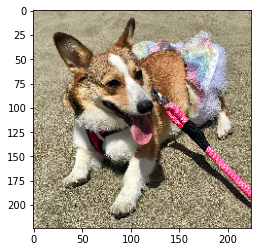

[[0.01399766 0.9860023 ]]
{'cat': 0, 'dog': 1}


In [20]:

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
print(prediction)
print(validation_generator.class_indices)